1.라이브러리 설치

In [29]:
# !conda install tensorflow==1.14 -y
# !conda install keras==2.2.5 -y
# !conda install h5py==2.10.0 -y


In [30]:
# %pip install opencv-python==4.5.1.48
# %pip install imgaug


In [31]:
# 2. video.zip 파일의 압축을 풀어줌

In [32]:
import zipfile

zip_file=zipfile.ZipFile("video2_3.zip")
zip_file.extractall()

3.라이브러리 불러오기

In [33]:
import os
import random
import fnmatch
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 180)

# tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'.keras.__version__: {tensorflow.keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__: 1.14.0
.keras.__version__: 2.2.4-tf


4.데이터 불러오기

image_path: .\video\train_00020_090.png
steering_Angle: 90


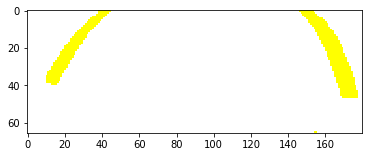

In [34]:
data_dir = r'.\video'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4]) 
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

5.조향각의 분포를 확인



(array([14601.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 16353.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        12503.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <a list of 25 Patch objects>)

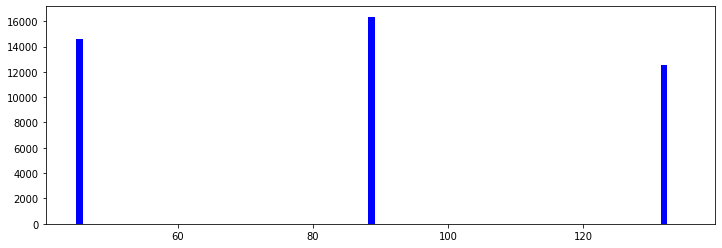

In [35]:
num_of_bins = 25 
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

6. 학습데이터와 검증데이터를 분리

Training data: 34765
Validation data: 8692


Text(0.5, 1.0, 'Validation Data')

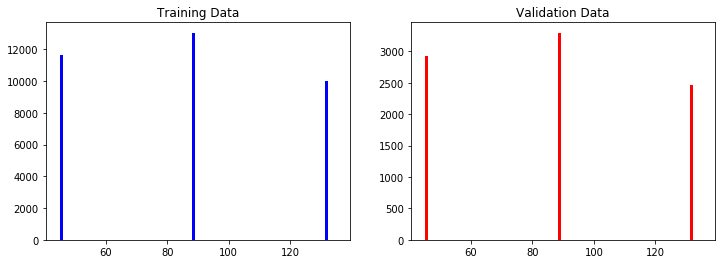

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

7. 이미지 읽어오기 및 정규화함수

Text(0.5, 1.0, 'processed')

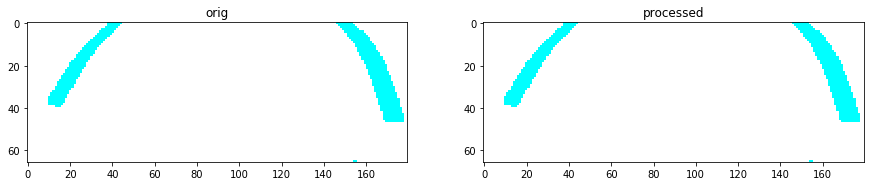

In [37]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    return image

def img_preprocess(image):
    image = image / 255
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

8. nvidia 모델구성

In [38]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')

    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 180, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), input_shape=(66, 180, 3), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), input_shape=(66, 180, 3), activation='elu')) 
    model.add(Conv2D(64, (3, 3), input_shape=(66, 180, 3), activation='elu')) 
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3),input_shape=(66, 180, 3),  activation='elu')) 

    model.add(Flatten())
    model.add(Dropout(0.2)) 
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model

model = nvidia_model()
print(model.summary())

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 88, 24)        1824      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 42, 36)        21636     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 5, 19, 48)         43248     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 3, 17, 64)         27712     
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 17, 64)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 15, 64)         36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 960)              

9. 학습데이터 생성

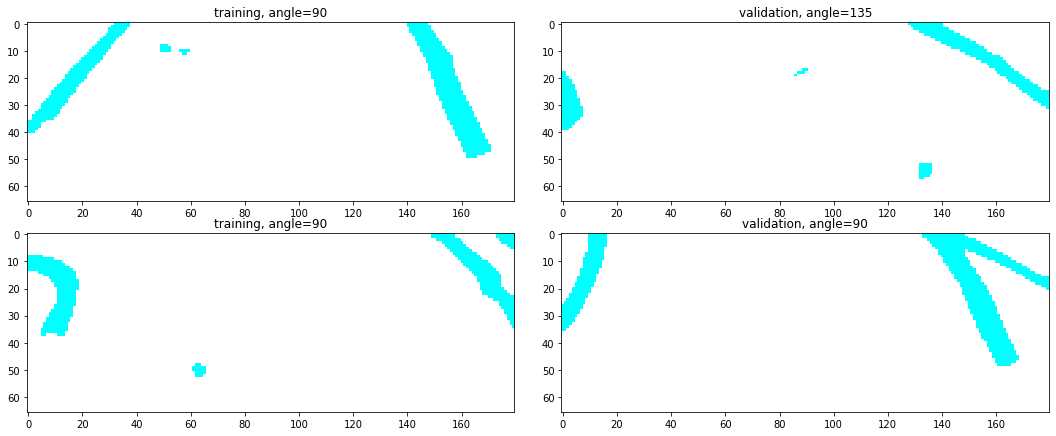

In [39]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

10.모델 학습(5~10분가량 소요)

In [40]:
model_output_dir = r"./"

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check2_3.h5'), verbose=1, save_best_only=True)
print(X_train, y_train)
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=100),
                              steps_per_epoch=350,
                              epochs=10,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir,'lane_navigation_final2_3.h5'))

history_path = os.path.join(model_output_dir,'history2_3.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

['.\\video\\train_10491_135.png', '.\\video\\train_09786_090.png', '.\\video\\train_00363_090.png', '.\\video\\train_29709_135.png', '.\\video\\train_38924_090.png', '.\\video\\train_31946_090.png', '.\\video\\train_19970_045.png', '.\\video\\train_06610_135.png', '.\\video\\train_09814_135.png', '.\\video\\train_33021_045.png', '.\\video\\train_30604_045.png', '.\\video\\train_09948_090.png', '.\\video\\train_42950_135.png', '.\\video\\train_02364_045.png', '.\\video\\train_28129_090.png', '.\\video\\train_02002_090.png', '.\\video\\train_41910_045.png', '.\\video\\train_26127_135.png', '.\\video\\train_24512_135.png', '.\\video\\train_28753_135.png', '.\\video\\train_01381_090.png', '.\\video\\train_03764_090.png', '.\\video\\train_19354_045.png', '.\\video\\train_05420_045.png', '.\\video\\train_13350_045.png', '.\\video\\train_08541_135.png', '.\\video\\train_23961_135.png', '.\\video\\train_36883_045.png', '.\\video\\train_39955_135.png', '.\\video\\train_24938_090.png', '.\\video

11. 결과확인

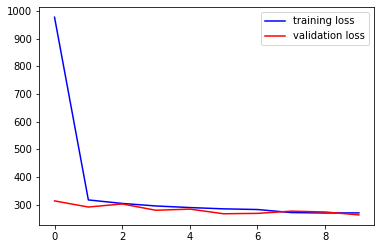

In [41]:
history.history

history_path = os.path.join(model_output_dir,'history2_3.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

12. 검증

mse       = 2.2e+02
r_squared = 82.15%



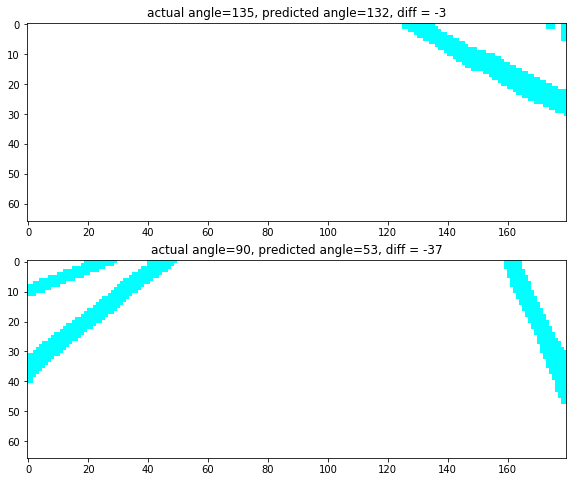

In [42]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check2_3.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")